# DSI Project 4 – Web Scraping of Job Posting 
## Executive Summary

Project 4 provides an opportunity to practice all the knowledge we have learnt so far, with a good mix of data processing, web scraping as well as NLP. The project requires student to scrape job information pertaining to data science and affiliated roles from career site based our choice. I chose Indeed.co.uk as I think majority of the students scrape US or Singapore data science career information, and I think it’s worth to look at the UK data. Initially, accessing individual webpage is planned, however, due to the challenges and extremely slow processing, the decision is decided to scrape only information available on the search page instead. The final processed data frame with salary status is shown below. The salary data has its own flaws as the total scraped entries are around 8000 , and this is not even 30% of it. However, with this, we still can obtain some insights.<br>

There are:
- total of 2848 entries
- 1920 permanent data related jobs and 928 fulltime data related jobs
- 604 data engineer, 593 business intelligence, 590 analytics, 546 data analyst, 515 research scientist , surprisingly no search result with job tag ‘data scientist’ has salary information. Interestingly, I get roughly the same amount of entries for each job search tag.
- Job posted more than 1 month has the largest number which is 759, the rest are quite low.
- ‘harnham’ is the company that provides the most number of data related jobs. From the total extracted data, ‘harnham’ is still the top employer. However, PCW become second, probably it does not like to disclose the salary when it hires. 
- London is the top city that has most data related jobs, and accounts for nearly 30% of the total job posts.

The salary data has its own flaws as the total scraped entries are around 8000 , and this is not even 30% of it. However, with this, we still can obtain some insights. Especially, the large number of outliers in salary is affecting the classification. The numerical values here, such as post_time (duration of job being posted) as well we no_of_review (number of people who reviewed jobs) has no clear relation with annual salary at all. Therefore, other features with texts are considered and thus the application of NLP. <br>

Logistic regression is used, as mentioned earlier, the numerical values are totally hopeless and could not establish clear relationship. Thus, NLP is a good application. In addition, I have classified the annual salary as high (1) or low (0), which is a binary outcome, and a perfect use case for logistic regression. The first classificaiton model is using logistic regression and Scikit Learn libirary packages. More sepecifically, the TfidfVectorizer as we are using the TF-IDF bag of n-grams approach. This is because we are using bag of words modeling, it is straightforward yet powerful.TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.<br>


A decision tree estimator is used to find out the important features. The job titles do have a significant importance compared to the other two features. However, it is still difficult to conclude which feature has importance to predict salary. A little bit insight is probably that titles with analyst, data scientist and data engineer are more important.<br>


When location data is added, it seems that now London and graduate has more impact. Apparently, from the EDA we can already tell that London has the highest number of jobs available for data related business. <br>


Interestingly, decision tree gives us the most important feature for the combined data is now 'engineer' and second by 'scientist'. Perhaps, the demand for data engineer or machine learning engineer is increasing. It seems these two models are not very good as the results are not consisten. As our baseline model says the top 2 important features are : location (london) and job title(graduate), and now the final model says the top 2 important features are both from job summary: engineer and scientist.



QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

    NLP
    Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
    Ensemble methods and decision tree models
    SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
#import scraped data
df_raw=pd.read_csv('combined.csv')
df_raw.head()

,Unnamed: 0,Unnamed: 0.1,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,0,0,jl_aefa77662d5bfc1d,fulltime,analytics,6 days ago,Head of Customer Insight & Analytics,Rank Group,NaN,Maidenhead,18 reviews,� Responsible for leading a team of Analysts a...
1,1,1,jl_719d91b70ae97f1c,fulltime,analytics,1 day ago,Head of Performance & Analytics,Barnet Clinical Commissioning Group,"£63,754 - £75,907 a year",Barnet,NaN,"Reporting to the Director of QIPP, Planning an..."
2,2,2,jl_d123655931ba246c,fulltime,analytics,43 minutes ago,Insights & Analytics Intern | 8 week summer pl...,Asos.com,NaN,London,233 reviews,Developing a great understanding of modern ana...
3,3,3,jl_72f97ac8201bc2a2,fulltime,analytics,30+ days ago,Intern (Data Analytics),Keppel Corporation,NaN,Keppel,3 reviews,Supports the Data Analytics team on project ba...
4,4,4,jl_bbd4d855dae0fede,fulltime,analytics,19 hours ago,Data & Analytics Analyst,RBS,NaN,Belfast,"2,920 reviews",Strong analytic and problem solving abilities....


In [3]:
df=df_raw.copy()

In [4]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [5]:
df.drop('Unnamed: 0.1',axis=1,inplace=True)

In [6]:
df

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6 days ago,Head of Customer Insight & Analytics,Rank Group,NaN,Maidenhead,18 reviews,� Responsible for leading a team of Analysts a...
1,jl_719d91b70ae97f1c,fulltime,analytics,1 day ago,Head of Performance & Analytics,Barnet Clinical Commissioning Group,"£63,754 - £75,907 a year",Barnet,NaN,"Reporting to the Director of QIPP, Planning an..."
2,jl_d123655931ba246c,fulltime,analytics,43 minutes ago,Insights & Analytics Intern | 8 week summer pl...,Asos.com,NaN,London,233 reviews,Developing a great understanding of modern ana...
3,jl_72f97ac8201bc2a2,fulltime,analytics,30+ days ago,Intern (Data Analytics),Keppel Corporation,NaN,Keppel,3 reviews,Supports the Data Analytics team on project ba...
4,jl_bbd4d855dae0fede,fulltime,analytics,19 hours ago,Data & Analytics Analyst,RBS,NaN,Belfast,"2,920 reviews",Strong analytic and problem solving abilities....
5,jl_e9ea6c3d4fca065a,fulltime,analytics,30+ days ago,Analytics Graduate Programme 2019-2020,Accenture,NaN,London,"14,997 reviews",Analytics Graduate Programme. The answer is An...
6,jl_cee98ab894ae35fa,fulltime,analytics,2 days ago,Reporting Analytics Manager,Homes England,"£30,300 - £58,580 a year",Birmingham B3,2 reviews,The Reporting and Analytics Manager will repor...
7,jl_b31a196a2fff5772,fulltime,analytics,1 day ago,"Advanced Analytics Consultant (Predictive, AI,...",Capita Plc,NaN,Edinburgh,"2,018 reviews",Become an Advanced Analytics Consultant with B...
8,jl_075807601f30181b,fulltime,analytics,6 hours ago,Innovus Summer Intern,Cadence Design Systems,NaN,Cambridge,147 reviews,O Excellent Creative Analytic Problem Solving ...
9,jl_6ee1d3010e922914,fulltime,analytics,1 day ago,Segment Analytics Lead,BP,NaN,Sunbury,"2,512 reviews",People Analytics experience. To build HR analy...


In [7]:
# convert all to small letters if string
df = df.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)

# remove all non-alphabets
df.job_title = df.job_title.map(lambda x: re.sub(r'[^A-Za-z\s]','',x).strip())

In [8]:
df.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6 days ago,head of customer insight analytics,rank group,NaN,maidenhead,18 reviews,� responsible for leading a team of analysts a...
1,jl_719d91b70ae97f1c,fulltime,analytics,1 day ago,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."


In [9]:
#check dupicates
df.job_id.nunique()==len(df)

False

In [10]:
print ('before drop duplicates: ',len(df))
df.drop_duplicates(subset='job_id',inplace=True)
print ()
print ('after dropping duplicates: ',len(df))

before drop duplicates:  9742

after dropping duplicates:  7595


In [11]:
df.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6 days ago,head of customer insight analytics,rank group,NaN,maidenhead,18 reviews,� responsible for leading a team of analysts a...
1,jl_719d91b70ae97f1c,fulltime,analytics,1 day ago,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."


In [12]:
#remove the + sign from job_tag, this should be removed during craping phase...
df['job_tag']=df['job_tag'].apply(lambda x:x.replace('+','_'))

In [13]:
df.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6 days ago,head of customer insight analytics,rank group,NaN,maidenhead,18 reviews,� responsible for leading a team of analysts a...
1,jl_719d91b70ae97f1c,fulltime,analytics,1 day ago,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."


In [14]:
# 'minutes' in (df.iloc[2]['post_time'].split())

In [15]:
#process post time
df['post_time']=df['post_time'].apply(lambda x: '1 day ago' if 'minutes'in x.split() or 'hours' in x.split() else x)

In [16]:
df['post_time']=df['post_time'].apply(lambda x: x.split()[0])

In [17]:
df.rename(columns={'post_time':'post_time_hrs_ago'}).head(2)

,job_id,job_types,job_tag,post_time_hrs_ago,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6,head of customer insight analytics,rank group,NaN,maidenhead,18 reviews,� responsible for leading a team of analysts a...
1,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."


In [18]:
#type(df.iloc[10]['no_of_review'])

In [19]:
#extract number of reviews
df['no_of_review']=df['no_of_review'].apply(lambda x:x.split()[0] if type(x)==str else x)

In [20]:
#df.iloc[1]['salary'].split()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7595 entries, 0 to 9741
Data columns (total 10 columns):
job_id          7595 non-null object
job_types       7595 non-null object
job_tag         7595 non-null object
post_time       7595 non-null object
job_title       7595 non-null object
company         7595 non-null object
salary          2848 non-null object
location        7595 non-null object
no_of_review    5082 non-null object
job_summary     7595 non-null object
dtypes: object(10)
memory usage: 652.7+ KB


In [22]:
df['salary'].describe()

count                         2848
unique                         872
top       £40,000 - £50,000 a year
freq                            61
Name: salary, dtype: object

In [23]:
df['salary'].value_counts()

£40,000 - £50,000 a year      61
£30,000 - £35,000 a year      61
£30,000 a year                53
£30,000 - £40,000 a year      52
£40,000 a year                48
£35,000 a year                45
£35,000 - £45,000 a year      44
£35,000 - £40,000 a year      43
£25,000 a year                43
£40,000 - £45,000 a year      40
£50,000 - £60,000 a year      38
£25,000 - £30,000 a year      36
£25,000 - £35,000 a year      33
£45,000 - £50,000 a year      33
£50,000 a year                32
£30,000 - £45,000 a year      30
£60,000 - £70,000 a year      29
£45,000 a year                29
£45,000 - £55,000 a year      27
£19,136 a year                27
£55,000 - £65,000 a year      25
£27,000 a year                24
£60,000 a year                24
£60,000 - £80,000 a year      23
£33,222 - £43,041 a year      21
£55,000 a year                20
£32,000 a year                20
£60,000 - £75,000 a year      19
£60,000 - £65,000 a year      18
£70,000 - £80,000 a year      18
          

In [24]:
df['job_types'].value_counts()

fulltime     4276
permanent    3319
Name: job_types, dtype: int64

As we can see it's quite tricky here to process the salary data as there are 872 unique ranges, and some value is by month, some even by week. Need to take the average if there are two values, and convert to yearly value

In [25]:
#extract those with no salary
df_no_salary=df[df['salary'].isnull()]

In [26]:
#extract df with salary
df_salary = df[~df['salary'].isnull()]
df_salary.reset_index(drop=True,inplace=True)
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 10 columns):
job_id          2848 non-null object
job_types       2848 non-null object
job_tag         2848 non-null object
post_time       2848 non-null object
job_title       2848 non-null object
company         2848 non-null object
salary          2848 non-null object
location        2848 non-null object
no_of_review    1473 non-null object
job_summary     2848 non-null object
dtypes: object(10)
memory usage: 222.6+ KB


In [27]:
#convert salary into yearly format
salary_range = df_salary.salary.map(lambda x: re.sub('[^0-9\s]', '', ' '.join(re.findall(r'\d+(?:[\d,.]*\d)', x))))
salary_period = df_salary.salary.map(lambda x: x[x.find('hour'):] if x.find('hour') >= 0 else x[x.find('day'):] if x.find('day') >= 0 
                                     else x[x.find('week'):] if x.find('week') else x[x.find('month'):] if x.find('month')>=0 else 'year')

In [28]:
salary_range.head()

0    63754 75907
1    30300 58580
2    39866 49704
3    70206 85333
4    23023 29608
Name: salary, dtype: object

In [29]:
df_salary.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,"£30,300 - £58,580 a year",birmingham b3,2,the reporting and analytics manager will repor...


In [30]:
salary_period.replace('r','year',inplace=True)

In [31]:
salary_period.replace('h','hour',inplace=True)

In [32]:
salary_period.value_counts()

year    2783
day       38
hour      23
week       4
Name: salary, dtype: int64

In [33]:
salary_period[salary_period=='day']

103     day
315     day
324     day
623     day
638     day
650     day
729     day
772     day
830     day
1249    day
1253    day
1267    day
1287    day
1323    day
1345    day
1418    day
1447    day
1616    day
1711    day
1847    day
1868    day
1892    day
1913    day
1937    day
1963    day
2035    day
2045    day
2048    day
2053    day
2070    day
2075    day
2088    day
2121    day
2203    day
2208    day
2247    day
2269    day
2324    day
Name: salary, dtype: object

In [34]:
len(salary_period) == len(salary_range)

True

In [35]:
len(salary_period)

2848

In [36]:
(salary_period.index == salary_range.index).sum()

2848

From here, we can tell that actually there is no salary given by month, mostly they were by year. We also confirmed taht the indexes of `salary_period` and `salary_range` are the same, and we can proceed with further transformation.

In [37]:
#test
# sal1 = salary_range[0].split()[0]
# sal2 = salary_range[0].split()[1]
# avg=(int(sal1) + int(sal2))/2
# avg


In [38]:
x =[]
for i in salary_range:
    x.append(len(i.split()))
0 in x

True

In [39]:
salary_range[salary_range=='']

1210    
2091    
Name: salary, dtype: object

Suprisingly, there are two values in the salary_range are ''

In [40]:
temp_sal = []

for i in range(0, len(salary_period)):
    if  salary_period.loc[i] == 'hour':
        if len(salary_range[i].split()) == 2:
            sal_h1 = int(salary_range[i].split()[0])
            sal_h2 = int(salary_range[i].split()[1])
            temp_sal.append(((sal_h1+sal_h2)/2)*8760)
            
        elif len(salary_range[i].split()) == 1:
            sal_h = int(salary_range[i].split()[0])
            temp_sal.append(sal_h*8760)
        else:
            temp_sal.append(np.nan)
    
    elif salary_period.loc[i] == 'day':        
        if len(salary_range[i].split()) == 2:
            sal_d1 = int(salary_range[i].split()[0])
            sal_d2 = int(salary_range[i].split()[1])
            temp_sal.append(((sal_d1+sal_d2)/2)*365)

        elif len(salary_range[i].split()) == 1:
            sal_d = int(salary_range[i])
            temp_sal.append((sal_d*365))
        else:
            temp_sal.append(np.nan)
    
    elif salary_period.loc[i] == 'week':
        if len(salary_range[i].split()) == 2:
            sal_w1 = int(salary_range[i].split()[0])
            sal_w2 = int(salary_range[i].split()[1])
            temp_sal.append(((sal_w1+sal_w2)/2)*52.143)
        elif len(salary_range[i].split()) == 1:
            sal_w = int(salary_range[i])
            temp_sal.append(sal_w*52.143)
        else:
            temp_sal.append(np.nan)
                        
    else:
        if len(salary_range[i].split()) == 2:
            sal_y1 = int(salary_range[i].split()[0])
            sal_y2 = int(salary_range[i].split()[1])
            temp_sal.append((sal_y1+sal_y2)/2)
        elif len(salary_range[i].split()) == 1:
            temp_sal.append(int(salary_range[i]))
        else:
            temp_sal.append(np.nan)
                                 
salary_annual = pd.DataFrame(temp_sal, columns=['salary_annual'])

In [41]:
salary_annual=salary_annual.fillna(0).astype(int) #cater the nan values

In [42]:
salary_higher_tier = salary_annual.applymap(lambda x: 1 if x> int(salary_annual.median()) else 0)

Prior to drop the salary column and solely looking the tierd salary, it's worth to do a ad-hoc EDA to understand some of the relationship.

In [43]:
df_salary.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,"£30,300 - £58,580 a year",birmingham b3,2,the reporting and analytics manager will repor...


In [44]:
#df_salary['job_types'].value_counts()

In [45]:
df_salary_copy =df_salary.copy()

In [46]:
#convert 30+ to 30
#first set all these numbers as laonger than 30 days
df_salary_copy['post_time']=df_salary_copy['post_time'].apply(lambda x: '39' if x=='30+' else x)

In [47]:
df_salary_copy['post_time']=df_salary_copy['post_time'].astype('int64')

df_salary_copy['no_of_review']=df_salary_copy['no_of_review'].fillna(0)

In [48]:
df_salary_copy['no_of_review']=df_salary_copy['no_of_review'].astype(str)

In [49]:
df_salary_copy['no_of_review']=df_salary_copy['no_of_review'].apply(lambda x: x.replace(',',''))

In [50]:
df_salary_copy['no_of_review']=df_salary_copy['no_of_review'].astype('int64')

In [51]:
df_salary.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,NaN,"reporting to the director of qipp, planning an..."
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,"£30,300 - £58,580 a year",birmingham b3,2,the reporting and analytics manager will repor...


In [52]:
df_salary['job_types'].value_counts()

permanent    1920
fulltime      928
Name: job_types, dtype: int64

In [53]:
df_salary_copy['job_types'].value_counts()

permanent    1920
fulltime      928
Name: job_types, dtype: int64

In [54]:
df_salary_copy.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,"£63,754 - £75,907 a year",barnet,0,"reporting to the director of qipp, planning an..."
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,"£30,300 - £58,580 a year",birmingham b3,2,the reporting and analytics manager will repor...


In [55]:
salary_annual.rename(columns={'salary_annual':'annual_salary'},inplace=True)

In [56]:
salary_annual.head(2)

,annual_salary
0,69830
1,44440


In [57]:
df_salary_copy.drop(labels=['salary'], axis=1, inplace=True)
df_salary_mod = pd.concat([df_salary_copy, salary_higher_tier,salary_annual], axis=1)

In [58]:
df_salary_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 11 columns):
job_id           2848 non-null object
job_types        2848 non-null object
job_tag          2848 non-null object
post_time        2848 non-null int64
job_title        2848 non-null object
company          2848 non-null object
location         2848 non-null object
no_of_review     2848 non-null int64
job_summary      2848 non-null object
salary_annual    2848 non-null int64
annual_salary    2848 non-null int32
dtypes: int32(1), int64(3), object(7)
memory usage: 233.7+ KB


In [59]:
df_salary_mod.rename(columns={'salary_annual':'salary_high_tier'},inplace=True)

In [60]:
df_salary_mod.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,location,no_of_review,job_summary,salary_high_tier,annual_salary
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,barnet,0,"reporting to the director of qipp, planning an...",1,69830
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,birmingham b3,2,the reporting and analytics manager will repor...,1,44440


Further process the this dataframe, as we can also categorize the post_time or we should change them to int

In [61]:
# df_salary_mod.iloc[4]['no_of_review']

In [62]:
df_no_salary.head(2)

,job_id,job_types,job_tag,post_time,job_title,company,salary,location,no_of_review,job_summary
0,jl_aefa77662d5bfc1d,fulltime,analytics,6,head of customer insight analytics,rank group,NaN,maidenhead,18,� responsible for leading a team of analysts a...
2,jl_d123655931ba246c,fulltime,analytics,1,insights analytics intern week summer place...,asos.com,NaN,london,233,developing a great understanding of modern ana...


Perhaps later need to apply the same process on no salary dataframe

## Simple EDA

In [63]:
df_salary_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 11 columns):
job_id              2848 non-null object
job_types           2848 non-null object
job_tag             2848 non-null object
post_time           2848 non-null int64
job_title           2848 non-null object
company             2848 non-null object
location            2848 non-null object
no_of_review        2848 non-null int64
job_summary         2848 non-null object
salary_high_tier    2848 non-null int64
annual_salary       2848 non-null int32
dtypes: int32(1), int64(3), object(7)
memory usage: 233.7+ KB


From all the scraped data, there are 2848 has salary values and they have been classified into high_tier (1) or not higher_tier

In [64]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

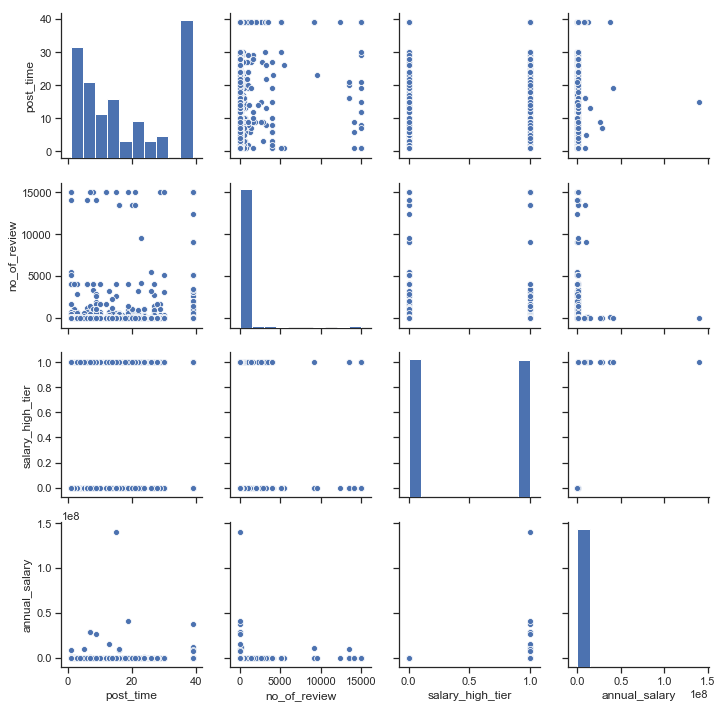

In [65]:
g = sns.pairplot(df_salary_mod)

In [66]:
df_salary_mod['job_types'].value_counts()

permanent    1920
fulltime      928
Name: job_types, dtype: int64

Text(0.5, 1.0, 'Number of permanent jobs vs. fulltime jobs')

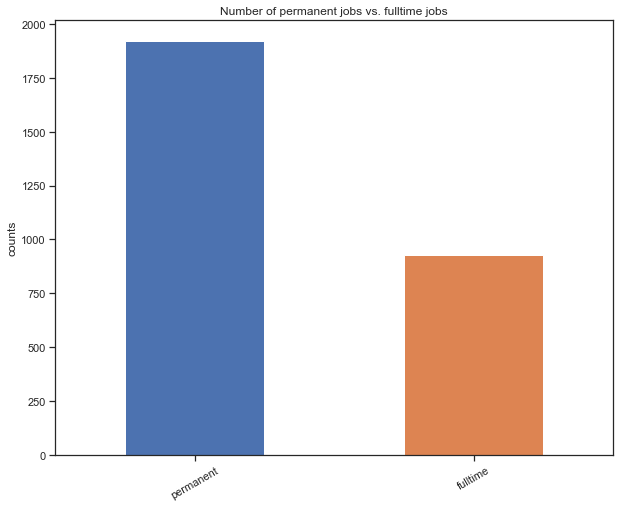

In [67]:
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod['job_types'].value_counts()
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Number of permanent jobs vs. fulltime jobs')

In [68]:
df_salary_mod['job_tag'].value_counts()

data_engineer            604
business_intelligence    593
analytics                590
data_analyst             546
research_scientist       515
Name: job_tag, dtype: int64

Text(0.5, 1.0, 'Distribution by job search tags')

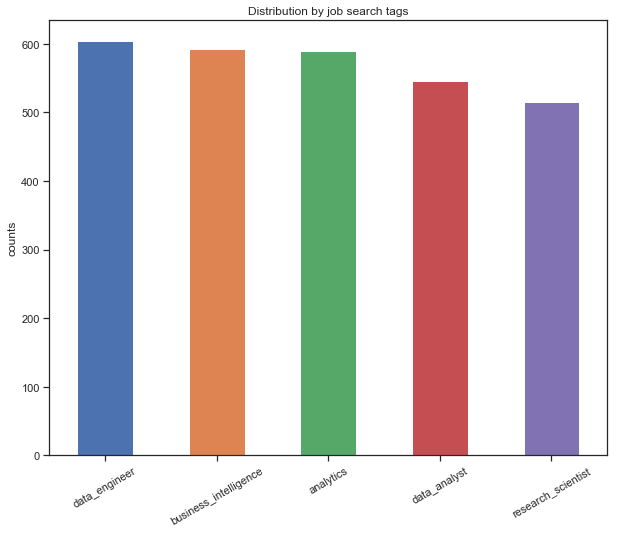

In [69]:
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod['job_tag'].value_counts()
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Distribution by job search tags')

In [70]:
df_salary_mod['post_time'].value_counts()

39    759
1     364
2     163
9     138
7     122
6     118
8     113
14     86
13     85
16     80
15     74
3      69
22     65
5      64
10     57
20     56
28     47
12     45
29     43
23     42
19     41
27     39
17     37
21     37
30     27
24     25
26     23
18     13
4      12
25      3
11      1
Name: post_time, dtype: int64

Text(0.5, 1.0, 'Distribution by duraiont of job posted')

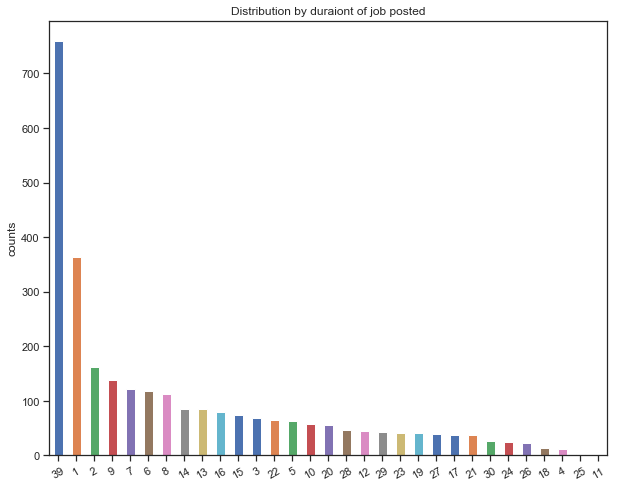

In [71]:
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod['post_time'].value_counts()
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Distribution by duraiont of job posted')

In [72]:
df_salary_mod.job_title.nunique()

2205

In [73]:
df_salary_mod.company.nunique()

1015

In [74]:
df_salary_mod.company.value_counts(ascending=False).head(10)

harnham                              253
michael page uk                       78
stfc                                  53
aspire data recruitment               41
accenture                             34
nigel frank international limited     29
ministry of defence                   23
re&m                                  22
mcgregor boyall                       21
nicholson glover consulting           21
Name: company, dtype: int64

Text(0.5, 1.0, 'Top 10 firms at UK hire data realted jobs with salary information')

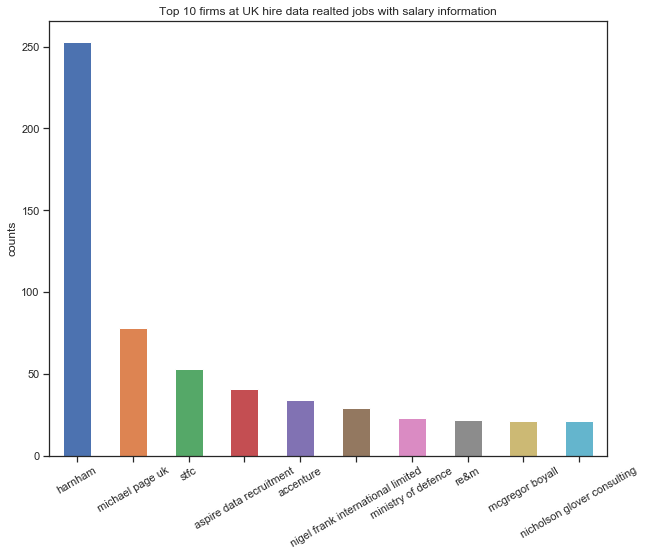

In [76]:
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod.company.value_counts(ascending=False).head(10)
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Top 10 firms at UK hire data realted jobs with salary information')

Text(0.5, 1.0, 'Top 10 firms at UK hire data realted jobs from total extracted data')

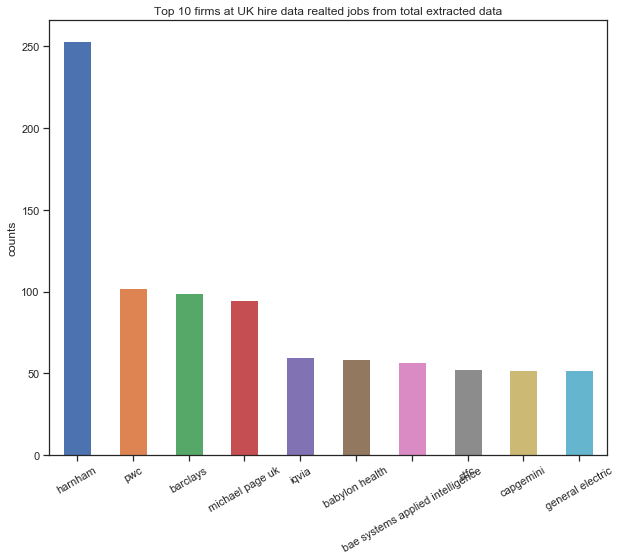

In [77]:
# #maybe we can take a look at the main dataframe
f, ax=plt.subplots(figsize=(10,8))
raw=df.company.value_counts(ascending=False).head(10)
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Top 10 firms at UK hire data realted jobs from total extracted data')

In [79]:
df_salary_mod['location'].nunique()

512

It seems the `job_title` and `location` does not really halp as there are too many numbers. We have 2205 different job titles, and 512 different locations

In [80]:
df_salary_mod['location'].value_counts(ascending=False).head(10)

london            912
manchester         66
united kingdom     66
didcot             57
leeds              47
oxford             46
cambridge          41
bristol            41
reading            39
birmingham         36
Name: location, dtype: int64

In [83]:
(df_salary_mod['location']=='london').sum() / len(df_salary_mod)

0.3202247191011236

In [81]:
df['location'].value_counts(ascending=False).head(10)

london            2463
united kingdom     273
reading            174
manchester         159
bristol            118
leeds              115
birmingham         103
edinburgh           97
cambridge           96
glasgow             87
Name: location, dtype: int64

In [84]:
(df['location']=='london').sum() / len(df)

0.324292297564187

Text(0.5, 1.0, 'Top 5 cities UK hire data realted jobs the most')

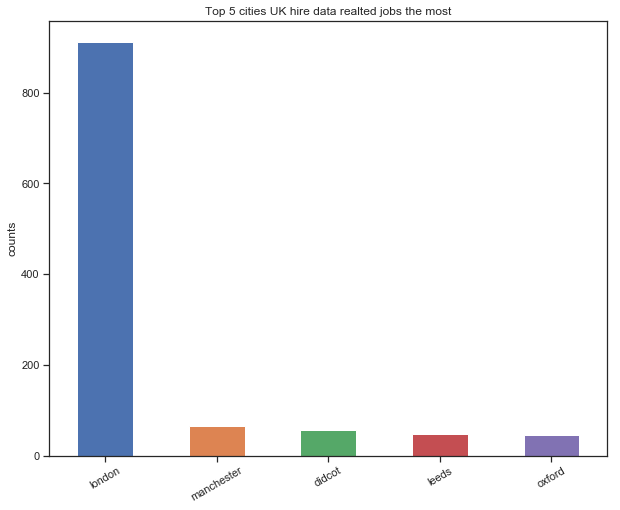

In [87]:
# #maybe we can take a look at the main dataframe
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod[df_salary_mod['location']!='united kingdom']['location'].value_counts(ascending=False).head(5)
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Top 5 cities UK hire data realted jobs the most')

Text(0.5, 1.0, 'Top 5 cities UK with most nubmer of high salary tier jobs')

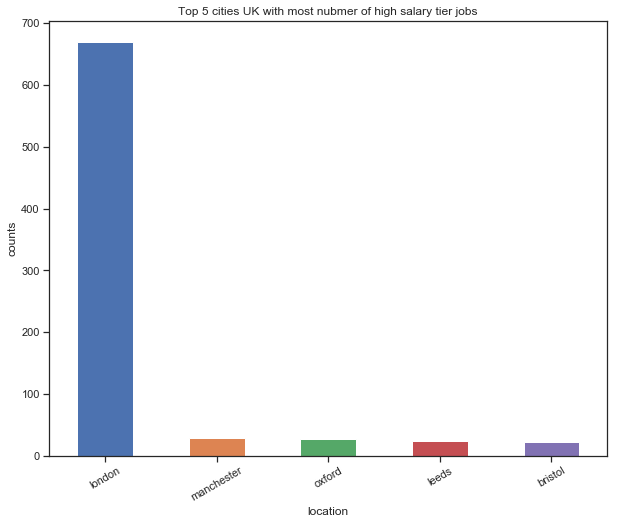

In [180]:
f, ax=plt.subplots(figsize=(10,8))
raw=df_salary_mod[df_salary_mod['location']!='united kingdom'].groupby(by='location')['salary_high_tier'].sum().sort_values(ascending=False).head(5)
raw.plot(kind='bar')
plt.xticks(rotation=30)
plt.ylabel('counts')
plt.title('Top 5 cities UK with most nubmer of high salary tier jobs')

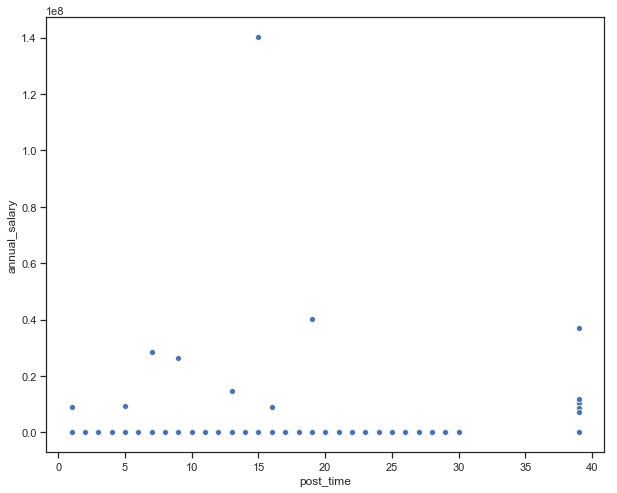

In [88]:
f, ax=plt.subplots(figsize=(10,8))
sns.scatterplot(x='post_time',y='annual_salary',data=df_salary_mod)

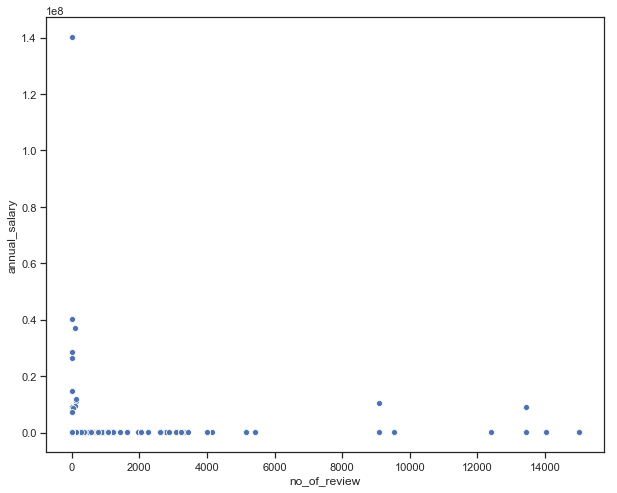

In [92]:
f, ax=plt.subplots(figsize=(10,8))
sns.scatterplot(x='no_of_review',y='annual_salary',data=df_salary_mod)

It seems there is no relationship bewteen number of reviews and post time. The outlier could due to the wrong calcualtion. It is worth to look at it.

In [93]:
df_salary_mod['annual_salary'].max()

140160000

In [95]:
df_salary_mod[df_salary_mod['annual_salary']==140160000]

,job_id,job_types,job_tag,post_time,job_title,company,location,no_of_review,job_summary,salary_high_tier,annual_salary
34,jl_363b5a67f5822e9e,fulltime,analytics,15,team support apprentice,whitehat training,london ec2a,0,document/information management control data a...,1,140160000


In [96]:
df_salary_mod[df_salary_mod['company']=='whitehat training']

,job_id,job_types,job_tag,post_time,job_title,company,location,no_of_review,job_summary,salary_high_tier,annual_salary
34,jl_363b5a67f5822e9e,fulltime,analytics,15,team support apprentice,whitehat training,london ec2a,0,document/information management control data a...,1,140160000
1795,jl_006e1da6841037e9,fulltime,data_engineer,23,software engineering apprenticeship,whitehat training,london nw1,0,"collaborate with other engineers, product mana...",0,18500


Reduce it to the same scale as the other post. 

In [100]:
df_salary_mod.iloc[34,-1]=14016

In [101]:
df_salary_mod[df_salary_mod['company']=='whitehat training']

,job_id,job_types,job_tag,post_time,job_title,company,location,no_of_review,job_summary,salary_high_tier,annual_salary
34,jl_363b5a67f5822e9e,fulltime,analytics,15,team support apprentice,whitehat training,london ec2a,0,document/information management control data a...,1,14016
1795,jl_006e1da6841037e9,fulltime,data_engineer,23,software engineering apprenticeship,whitehat training,london nw1,0,"collaborate with other engineers, product mana...",0,18500


In [103]:
df_salary_mod.iloc[34,-2]=0

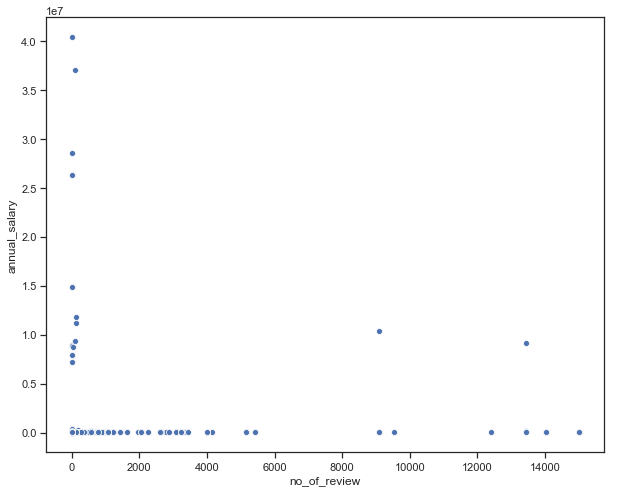

In [102]:
f, ax=plt.subplots(figsize=(10,8))
sns.scatterplot(x='no_of_review',y='annual_salary',data=df_salary_mod)

In [109]:
df_salary_mod['annual_salary'].sort_values(ascending=False).head(50)

1713    40374840
354     37011000
979     28540080
1027    28540080
1768    26306280
2410    14874480
2301    11826000
624     11212800
754     10319280
1330     9320640
2534     9154200
613      8952720
1175     8882640
2449     8760000
441      7884000
2610     7244520
2623      363540
1856      328500
990       280320
1323      219000
1892      200750
1616      200750
315       191625
1345      187062
1868      182682
830       182500
1847      182500
1873      180000
2035      151475
2090      150000
638       146000
2072      145000
2780      140000
1165      140000
240       140000
997       137500
1267      136875
419       135000
650       133225
1447      127750
384       125000
119       122640
1119      120000
370       120000
178       115000
1099      115000
1030      110000
2540      110000
337       110000
408       110000
Name: annual_salary, dtype: int32

In [110]:
outliers=df_salary_mod[df_salary_mod['annual_salary']>=7244520]

In [112]:
#drop the extremely high salaries
df_salary_mod.drop(outliers.index,inplace=True)

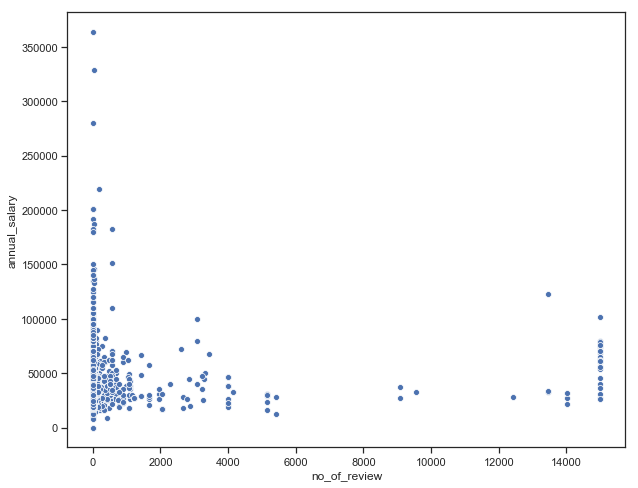

In [113]:
f, ax=plt.subplots(figsize=(10,8))
sns.scatterplot(x='no_of_review',y='annual_salary',data=df_salary_mod)

Although dropped the number of reviews, it seem there are still no clear relationship. It seems there is no relationship between number of reviews and the salary.

In [114]:
df_salary_mod['salary_high_tier'].value_counts()

0    1427
1    1405
Name: salary_high_tier, dtype: int64

We now need to reasign the higher tier as we removed the outliers.

In [117]:
median_num=df_salary_mod['annual_salary'].median()
median_num

38131.0

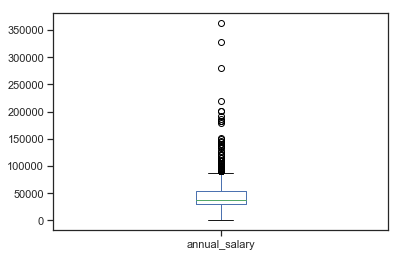

In [116]:
df_salary_mod['annual_salary'].plot(kind='box')

It seems there are quite a number of outliers. However, it is challenging to deal with it.

In [119]:
df_salary_mod['salary_higher_tier_2']=df_salary_mod['annual_salary'].apply(lambda x:1 if x>median_num else 0)

In [120]:
df_salary_mod

,job_id,job_types,job_tag,post_time,job_title,company,location,no_of_review,job_summary,salary_high_tier,annual_salary,salary_higher_tier_2
0,jl_719d91b70ae97f1c,fulltime,analytics,1,head of performance analytics,barnet clinical commissioning group,barnet,0,"reporting to the director of qipp, planning an...",1,69830,1
1,jl_cee98ab894ae35fa,fulltime,analytics,2,reporting analytics manager,homes england,birmingham b3,2,the reporting and analytics manager will repor...,1,44440,1
2,jl_cf231c48d7af807d,fulltime,analytics,8,contracting analytics specialist,nel,london se1,7,"we are looking for an enthusiastic, experience...",1,44785,1
3,jl_93d5326817f2029b,fulltime,analytics,22,assistant director of analytics deputy cio,east lancashire hospitals nhs trust,blackburn bb2,13,the directorate is looking to employ an assist...,1,77769,1
4,jl_9bf799089eefea91,fulltime,analytics,6,business support officer,nhs england,leeds ls2,4005,"we are particularly interested, across these r...",0,26315,0
5,jl_59af1463838f3be9,fulltime,analytics,28,research assistant in holoscopic d imaging and...,brunel university,uxbridge,60,this involves low-level visual media analysis ...,0,36728,0
6,jl_d9fd8c914a29b393,fulltime,analytics,1,research fellow real estate urban informatics...,oxford brookes university,oxford,70,to email the post of research fellow - real es...,0,31302,0
7,jl_0f3be053e7ae782d,fulltime,analytics,39,month placement it data analytics july,bmw,oxfordshire,2057,<br><br>we are currently seeking a student wit...,0,17500,0
8,jl_5873a76350c2f1ef,fulltime,analytics,7,business intelligence officer,central and north west london nhs foundation t...,london nw1,16,as a business intelligence officer you will be...,0,34305,0
9,jl_500e1d5f202379f6,fulltime,analytics,1,finance assistant,nhs herts valleys clinical commissioning group,hemel hempstead hp2,4005,they will contribute to preparatory work on mo...,0,21756,0


In [122]:
(df_salary_mod['salary_higher_tier_2'] == df_salary_mod['salary_high_tier']).sum()

2832

In [123]:
len(df_salary_mod)

2832

It seems the outlier are heavliy affecting the median.

## BAG OF WORDS MODELLING¶

# Question 1:

Get TFIDF of job title, company, location, summary. Use data with salary to predict those without.From out features with highest significant in distinguishing high vs low salary jobs. Then collect TFIDF again for whole dataset and do second round of modelling. Check to see whether top features are the same with round 1. Features that appear highly significant in both rounds are the factors that are best at distinguishing.high vs low salaryFor my study, i will generate features from my dataset using TFIDF. Then I will use log reg and decision tree to predict, unless results really bad. It seems there is no need to do processing for the data with no salary since most of the features we are using is the nlp, not really numerical data.

In [151]:
print (df_salary_mod.columns)

Index(['job_id', 'job_types', 'job_tag', 'post_time', 'job_title', 'company',
       'location', 'no_of_review', 'job_summary', 'salary_high_tier',
       'annual_salary', 'salary_higher_tier_2'],
      dtype='object')


In [152]:
#notice that the removing of extreme outliers does not affect the tier
q1_col=['job_title', 'company','location', 'job_summary', 'salary_high_tier']

In [155]:
q1_salary=df_salary_mod[q1_col]
q1_salary.head(2)

,job_title,company,location,job_summary,salary_high_tier
0,head of performance analytics,barnet clinical commissioning group,barnet,"reporting to the director of qipp, planning an...",1
1,reporting analytics manager,homes england,birmingham b3,the reporting and analytics manager will repor...,1


Logistic regression are used, as mentioned earlier, the numerical values are totally hopeless and could not establish clear relationship. Thus, NLP is a good application. The first classificaiton model is using logistic regression and Scikit Learn libirary packages. More sepecifically, the TfidfVectorizer as we are using the TF-IDF bag of n-grams approach. This is because we are using bag of words modeling, it is straightforward yet powerful.TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [157]:
# Get TFIDF for job summary
job_summary_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_summary_tvec.fit(q1_salary['job_summary'])
job_summary_tvec_df = pd.DataFrame(job_summary_tvec.transform(q1_salary['job_summary']).todense(),
                       columns=['summary_[' + f + ']' for f in job_summary_tvec.get_feature_names()])

In [158]:
# Get TFIDF for job title
job_title_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_title_tvec.fit(q1_salary['job_title'])
job_title_tvec_df = pd.DataFrame(job_title_tvec.transform(q1_salary['job_title']).todense(),
                       columns=['title_[' + f + ']' for f in job_title_tvec.get_feature_names()])

In [159]:
# Get TFIDF for company name
job_company_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_company_tvec.fit(q1_salary['company'])
job_company_tvec_df = pd.DataFrame(job_company_tvec.transform(q1_salary['company']).todense(),
                       columns=['company_[' + f + ']' for f in job_company_tvec.get_feature_names()])

In [160]:
# Get TFIDF for company location
job_location_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_location_tvec.fit(q1_salary['location'])
job_location_tvec_df = pd.DataFrame(job_company_tvec.transform(q1_salary['location']).todense(),
                       columns=['location_[' + f + ']' for f in job_company_tvec.get_feature_names()])

In [161]:
y_with_sal = q1_salary['salary_high_tier']
X_with_sal = pd.concat([job_summary_tvec_df,job_title_tvec_df,job_company_tvec_df,job_location_tvec_df], axis=1)

In [162]:
# Get training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_with_sal, y_with_sal, test_size=0.3, random_state=42)

In [163]:
# Standardize predictors
X_train_ss = StandardScaler().fit_transform(X_train)
X_test_ss = StandardScaler().fit_transform(X_test)

In [164]:
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_train.columns)

In [165]:
# Fit with plain logistic regression
lr = LogisticRegression()
lr.fit(X_train_ss, y_train)

C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [166]:
pred = lr.predict(X_test_ss)
score = metrics.f1_score(y_test, pred)
print(classification_report(y_test, pred))
print('f1-score:', score)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       450
           1       0.70      0.76      0.73       400

   micro avg       0.73      0.73      0.73       850
   macro avg       0.73      0.73      0.73       850
weighted avg       0.73      0.73      0.73       850

f1-score: 0.7259615384615385


With a precision of 0.69 and recall of 0.7, it seems not that bad at first, having both high precision and recall at the same time. However, take note that this is only the baseline model. <br>
Next, try Gridsearch for Ridge and Lasso Logistic Regression in the hope to optimize the model.

In [167]:
# Gridsearch for Ridge and Lasso Logistic Regression

parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

print ("GRID SEARCH:")
lr_grid_search = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=0)
lr_grid_search.fit(X_train_ss, y_train)
print ("Best parameters set:")
lr_best_parameters = lr_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, lr_best_parameters[param_name]))

GRID SEARCH:
Best parameters set:
	C: 0.012045035402587823
	penalty: 'l2'
	solver: 'liblinear'


In [168]:
print ("Logistic Regression with best parameter:")
clf = LogisticRegression(**lr_best_parameters)
clf.fit(X_train_ss, y_train)
lr_gs_pred = clf.predict(X_test_ss)
print(metrics.classification_report(y_test, lr_gs_pred, labels=[1,0], target_names=['high salary','low salary']))

Logistic Regression with best parameter:
              precision    recall  f1-score   support

 high salary       0.71      0.74      0.73       400
  low salary       0.76      0.73      0.75       450

   micro avg       0.74      0.74      0.74       850
   macro avg       0.74      0.74      0.74       850
weighted avg       0.74      0.74      0.74       850



Using the best paramters does not seem to improve our baseline.This time round, decisiontree is used.Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves).

In [169]:
from sklearn.tree import DecisionTreeClassifier

In [170]:
# gridsearch params
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [171]:
dtc_gs.fit(X_train_ss, y_train)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:    8.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [172]:
# Best Estimator
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 40}
0.6892028254288597


In [173]:
fi = pd.DataFrame({
        'feature':X_train_ss.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
85,location_[london],0.094337
39,title_[graduate],0.060173
33,title_[data engineer],0.052786
25,title_[analyst],0.047338
1,summary_[analytics],0.045603
40,title_[head],0.043114
47,title_[senior],0.032811
31,title_[data],0.032625
3,summary_[business],0.032550
0,summary_[analyst],0.027236


In [174]:
coef = lr_grid_search.best_estimator_.coef_
lr_coef = pd.DataFrame({'coef':coef.ravel(),
                    'mag':np.abs(coef.ravel()),
                    'pred':X_test_ss.columns})

lr_coef.sort_values('mag', ascending=False, inplace=True)
lr_coef.head(10)

,coef,mag,pred
85,0.437236,0.437236,location_[london]
40,0.373235,0.373235,title_[head]
39,-0.345173,0.345173,title_[graduate]
43,0.293432,0.293432,title_[manager]
42,0.234805,0.234805,title_[lead]
57,0.208388,0.208388,company_[harnham]
26,0.206738,0.206738,title_[analytics]
34,0.206700,0.206700,title_[data scientist]
38,0.194499,0.194499,title_[engineer]
47,0.193157,0.193157,title_[senior]


In [175]:
pred = dtc_best.predict(X_test_ss)
print(classification_report(y_test, pred, labels=[1,0], target_names=['high salary','low salary']))

              precision    recall  f1-score   support

 high salary       0.61      0.68      0.65       400
  low salary       0.69      0.62      0.65       450

   micro avg       0.65      0.65      0.65       850
   macro avg       0.65      0.65      0.65       850
weighted avg       0.65      0.65      0.65       850



For now, logistic regression has slightly better score comapred to decision tree model.

In [176]:
df_no_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747 entries, 0 to 9741
Data columns (total 10 columns):
job_id          4747 non-null object
job_types       4747 non-null object
job_tag         4747 non-null object
post_time       4747 non-null object
job_title       4747 non-null object
company         4747 non-null object
salary          0 non-null object
location        4747 non-null object
no_of_review    3609 non-null object
job_summary     4747 non-null object
dtypes: object(10)
memory usage: 407.9+ KB


In [182]:
q1_no_salary=df_no_salary[['job_title', 'company','location', 'job_summary']]
q1_no_salary.head()

,job_title,company,location,job_summary
0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...
2,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...
3,intern data analytics,keppel corporation,keppel,supports the data analytics team on project ba...
4,data analytics analyst,rbs,belfast,strong analytic and problem solving abilities....
5,analytics graduate programme,accenture,london,analytics graduate programme. the answer is an...


In [186]:
# Get TFIDF for job title
job_title_tvec_nosal = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_title_tvec_nosal.fit(q1_no_salary['job_title'])
job_title_tvec_nosal_df = pd.DataFrame(job_title_tvec_nosal.transform(q1_no_salary['job_title']).todense(),
                       columns=['title_[' + f + ']' for f in job_title_tvec_nosal.get_feature_names()])

In [187]:
# Get TFIDF for job summary
job_summary_tvec_nosal = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_summary_tvec_nosal.fit(q1_no_salary['job_summary'])
job_summary_tvec_nosal_df = pd.DataFrame(job_summary_tvec_nosal.transform(q1_no_salary['job_summary']).todense(),
                       columns=['title_[' + f + ']' for f in job_summary_tvec_nosal.get_feature_names()])

In [188]:
# Get TFIDF for company
job_company_tvec_nosal = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_company_tvec_nosal.fit(q1_no_salary['company'])
job_company_tvec_nosal_df = pd.DataFrame(job_company_tvec_nosal.transform(q1_no_salary['company']).todense(),
                       columns=['title_[' + f + ']' for f in job_company_tvec_nosal.get_feature_names()])

In [189]:
# Get TFIDF for location
job_location_tvec_nosal = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_location_tvec_nosal.fit(q1_no_salary['location'])
job_location_tvec_nosal_df = pd.DataFrame(job_location_tvec_nosal.transform(q1_no_salary['location']).todense(),
                       columns=['title_[' + f + ']' for f in job_location_tvec_nosal.get_feature_names()])

In [190]:
X_without_sal = pd.concat([job_title_tvec_nosal_df,job_summary_tvec_nosal_df,job_company_tvec_nosal_df,job_location_tvec_nosal_df], axis=1)

In [191]:
# Standardize predictors
X_without_sal_ss = StandardScaler().fit_transform(X_without_sal)

In [192]:
X_without_sal_ss = pd.DataFrame(X_without_sal_ss, columns=X_without_sal.columns)

In [196]:
pred = dtc_best.predict(X_without_sal_ss)
q1_no_salary['salary'] = pred
q1_no_salary.rename(index=str, columns={"salary": "salary_high_tier"}, inplace=True)

C:\Users\zhixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zhixi\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [197]:
q1_no_salary.head()

,job_title,company,location,job_summary,salary_high_tier
0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...,0
2,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...,0
3,intern data analytics,keppel corporation,keppel,supports the data analytics team on project ba...,0
4,data analytics analyst,rbs,belfast,strong analytic and problem solving abilities....,0
5,analytics graduate programme,accenture,london,analytics graduate programme. the answer is an...,0


In [198]:
q1_no_salary['salary_high_tier'].value_counts()

0    2872
1    1875
Name: salary_high_tier, dtype: int64

In [199]:
# Merge predicted with original
final_df = pd.concat([q1_no_salary, q1_salary], axis=0, ignore_index=True)

In [200]:
len(final_df)

7579

In [201]:
final_df.head()

,job_title,company,location,job_summary,salary_high_tier
0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...,0
1,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...,0
2,intern data analytics,keppel corporation,keppel,supports the data analytics team on project ba...,0
3,data analytics analyst,rbs,belfast,strong analytic and problem solving abilities....,0
4,analytics graduate programme,accenture,london,analytics graduate programme. the answer is an...,0


In [202]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7579 entries, 0 to 7578
Data columns (total 5 columns):
job_title           7579 non-null object
company             7579 non-null object
location            7579 non-null object
job_summary         7579 non-null object
salary_high_tier    7579 non-null int64
dtypes: int64(1), object(4)
memory usage: 296.1+ KB


In [204]:
final_df['salary_high_tier'].value_counts()

0    4299
1    3280
Name: salary_high_tier, dtype: int64

In [205]:
# Get TFIDF for job title
job_title_tvec_final = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_title_tvec_final.fit(final_df.job_title)
job_title_tvec_final_df = pd.DataFrame(job_title_tvec_final.transform(final_df.job_title).todense(),
                       columns=['title_[' + f + ']' for f in job_title_tvec_final.get_feature_names()])

In [206]:
# Get TFIDF for job summary
job_summary_tvec_final = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_summary_tvec_final.fit(final_df['job_summary'])
job_summary_tvec_final_df = pd.DataFrame(job_summary_tvec_final.transform(final_df['job_summary']).todense(),
                       columns=['summary_[' + f + ']' for f in job_summary_tvec_final.get_feature_names()])

In [207]:
# Get TFIDF for company name
job_company_tvec_final = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_company_tvec_final.fit(final_df['company'])
job_company_tvec_final_df = pd.DataFrame(job_company_tvec_final.transform(final_df['company']).todense(),
                       columns=['company_[' + f + ']' for f in job_company_tvec_final.get_feature_names()])

In [208]:
# Get TFIDF for location 
job_location_tvec_final = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_location_tvec_final.fit(final_df['location'])
job_location_tvec_final_df = pd.DataFrame(job_location_tvec_final.transform(final_df['location']).todense(),
                       columns=['company_[' + f + ']' for f in job_location_tvec_final.get_feature_names()])

In [209]:
X = pd.concat([job_title_tvec_final_df, job_summary_tvec_final_df, job_company_tvec_final_df,job_location_tvec_final_df], axis=1)
y = final_df['salary_high_tier']

In [210]:
# Standardize predictors
Xs = StandardScaler().fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=42)

In [212]:
# Gridsearch for Ridge and Lasso Logistic Regression, optimize C

parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

print ("GRID SEARCH:")
lr_grid_search = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=0)
lr_grid_search.fit(X_train, y_train)
print ("Best parameters set:")
lr_best_parameters = lr_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, lr_best_parameters[param_name]))

GRID SEARCH:
Best parameters set:
	C: 0.04328761281083057
	penalty: 'l1'
	solver: 'liblinear'


In [213]:
print("Logistic Regression with best param:")
clf = LogisticRegression(**lr_best_parameters)
clf.fit(X_train, y_train)
lr_gs_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, lr_gs_pred, labels=[1,0], target_names=['high salary','low salary']))

Logistic Regression with best param:
              precision    recall  f1-score   support

 high salary       0.73      0.64      0.68      1050
  low salary       0.76      0.83      0.79      1452

   micro avg       0.75      0.75      0.75      2502
   macro avg       0.74      0.73      0.74      2502
weighted avg       0.75      0.75      0.74      2502



In [214]:
# Gridsearch params for decision tree classifier
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [215]:
# use the gridsearch C model to fit the data
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:   19.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [216]:
# Best Estimator
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'max_depth': None, 'max_features': None, 'min_samples_split': 50}
0.7167618672444357


In [217]:
pred = dtc_best.predict(X_test)
print(classification_report(y_test, pred, labels=[1,0], target_names=['high salary','low salary']))

              precision    recall  f1-score   support

 high salary       0.70      0.69      0.69      1050
  low salary       0.78      0.78      0.78      1452

   micro avg       0.74      0.74      0.74      2502
   macro avg       0.74      0.74      0.74      2502
weighted avg       0.74      0.74      0.74      2502



It seems for the final nmodel, the decision tree and logistic regression achieve similar results.

In [218]:
fi = pd.DataFrame({
        'feature':X_train.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
33,summary_[engineer],0.110808
44,summary_[scientist],0.058249
41,summary_[new],0.052027
27,summary_[analytics],0.049484
0,title_[analyst],0.043906
21,title_[senior],0.043271
40,summary_[management],0.032787
55,company_[harnham],0.030893
39,summary_[looking],0.026596
36,summary_[information],0.024826


In [219]:
lr_coef = pd.DataFrame({'coef':clf.coef_.ravel(),
                    'mag':np.abs(clf.coef_.ravel()),
                    'pred':X_test.columns})

lr_coef.sort_values('mag', ascending=False, inplace=True)
lr_coef.head(10)

,coef,mag,pred
33,0.514950,0.514950,summary_[engineer]
44,0.402233,0.402233,summary_[scientist]
41,0.330121,0.330121,summary_[new]
27,0.299814,0.299814,summary_[analytics]
40,-0.273622,0.273622,summary_[management]
21,0.272458,0.272458,title_[senior]
0,-0.266348,0.266348,title_[analyst]
55,0.234146,0.234146,company_[harnham]
39,0.207034,0.207034,summary_[looking]
86,0.196601,0.196601,company_[london]


Interstingly, decision tree gives us the most important feature for the combined data is now 'engineer' and second by 'scientist'. Perhaps, the demand for data engineer or machine learning engineer is increasing. It seems these two models are not very good as the results are not consisten. As our baseline model says the top 2 important features are : location (london) and job title(graduate), and now the final model says the top 2 important features are both from job summary: engineer and scientist. 

In [220]:
final_df.to_csv('q1_final.csv')

In [321]:
final_df.head(2)

,job_title,company,location,job_summary,salary_high_tier
0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...,0
1,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...,0


## Question 2
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

    What components of a job posting distinguish data scientists from other data jobs?
    What features are important for distinguishing junior vs. senior positions?
    Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [322]:
#q2_df =final_df.copy()

In [2]:
q2_df=pd.read_csv('q1_final.csv')

In [3]:
q2_df.head(2)

,Unnamed: 0,job_title,company,location,job_summary,salary_high_tier
0,0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...,0
1,1,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...,0


In [4]:
q2_df.columns

Index(['Unnamed: 0', 'job_title', 'company', 'location', 'job_summary',
       'salary_high_tier'],
      dtype='object')

In [5]:
q2_df.drop('Unnamed: 0',inplace=True,axis=1)
q2_df.head(2)

,job_title,company,location,job_summary,salary_high_tier
0,head of customer insight analytics,rank group,maidenhead,� responsible for leading a team of analysts a...,0
1,insights analytics intern week summer place...,asos.com,london,developing a great understanding of modern ana...,0


In [6]:
data_jobs = q2_df[q2_df['job_title'].str.contains('data')]

In [7]:
non_data_jobs = q2_df[~q2_df['job_title'].str.contains('data')]

In [8]:
data_jobs.shape

(1347, 5)

In [9]:
non_data_jobs.shape

(6232, 5)

In [10]:
analyst_job=non_data_jobs[non_data_jobs['job_title'].str.contains('analyst')]
non_analyst_job=non_data_jobs[~non_data_jobs['job_title'].str.contains('analyst')]

In [11]:
analyst_job.shape

(1313, 5)

In [12]:
non_analyst_job.shape

(4919, 5)

In [13]:
# database_job = non_analyst_job[non_analyst_job['job_title'].str.contains('database')]
# # non_database_job=non_analyst_job[~non_analyst_job['job_title'].str.contains('database')]

In [14]:
# database_job.shape

In [15]:
# non_database_job.shape

In [16]:
engineer_job=non_analyst_job[non_analyst_job['job_title'].str.contains('engineer')]
non_engineer_job=non_analyst_job[~non_analyst_job['job_title'].str.contains('engineer')]

In [17]:
engineer_job.shape

(1397, 5)

In [18]:
non_engineer_job.shape

(3522, 5)

In [19]:
manager_job=non_engineer_job[non_engineer_job['job_title'].str.contains('manager')]
non_manger_job=non_engineer_job[~non_engineer_job['job_title'].str.contains('manager')]

In [20]:
manager_job.shape

(677, 5)

In [21]:
non_manger_job.shape

(2845, 5)

In [22]:
non_manger_job['job_title'].value_counts(ascending=False)

bi developer                                                  20
business intelligence developer                               16
business development executive                                13
product owner                                                  9
marketing assistant                                            9
senior scientist                                               8
buyer                                                          8
research associate                                             6
machine learning scientist                                     5
head of analytics                                              5
marketing executive                                            5
research scientist                                             5
research technician                                            4
social media executive                                         4
biomedical scientist                                           4
analytics director       

In [23]:
scientist=non_manger_job[non_manger_job['job_title'].str.contains('scientist')]
non_scientist=non_manger_job[~non_manger_job['job_title'].str.contains('scientist')]

In [24]:
scientist.shape

(363, 5)

In [25]:
non_scientist.shape

(2482, 5)

In [26]:
research_job=non_scientist[non_scientist['job_title'].str.contains('research')]

In [27]:
non_research_job=non_scientist[~non_scientist['job_title'].str.contains('research')]

In [28]:
research_job.shape

(157, 5)

In [29]:
non_research_job.shape

(2325, 5)

In [30]:
non_research_job['job_title'].value_counts(ascending=False).head(10)

bi developer                       20
business intelligence developer    16
business development executive     13
marketing assistant                 9
product owner                       9
buyer                               8
marketing executive                 5
head of analytics                   5
analytics director                  4
frontend developer                  4
Name: job_title, dtype: int64

In [31]:
bi_job = non_research_job[(non_research_job['job_title'].str.contains('bi'))|(non_research_job['job_title'].str.contains('intelligence'))]
non_bi_job= non_research_job[(~non_research_job['job_title'].str.contains('bi'))&(~non_research_job['job_title'].str.contains('intelligence'))]

In [32]:
bi_job.shape

(217, 5)

In [33]:
non_bi_job.shape

(2108, 5)

In [34]:
bi_job

,job_title,company,location,job_summary,salary_high_tier
47,intelligence intern months,airbus group,leicester,"this role will sit in the energy, infrastructu...",0
130,scientific editor environmental science and su...,elsevier,united kingdom,"elsevier is part of relx group, a global provi...",1
139,european pharma biopharma applications develo...,thermo fisher scientific,hemel hempstead,collaborative approach to developing and shari...,1
211,junior security intelligence operations sioc ...,ibm,london,our goal in our sioc practice for our consulta...,0
269,game developer big pixel studios,time warner,london,balance progression and difficulty curves base...,1
273,global anticounterfeiting intelligence and enf...,glaxosmithkline,london,experience of performing online investigations...,1
300,billing assistant,freshfields bruckhaus deringer llp,manchester,"in addition, the team provides support and gui...",0
311,business intelligence and analytics graduate,pa consulting group,london,your role in business intelligence & analytics...,0
386,market intelligence specialist associate,blackrock,london,excellent analytic and creative problem solvin...,0
392,business intelligence and analytics industrial...,pa consulting group,london,business intelligence & analytics industrial p...,0


In [35]:
df = pd.DataFrame()
data_jobs.job_title = data_jobs.job_title.map(lambda x: 'data_jobs')
analyst_job.job_title = analyst_job.job_title.map(lambda x: 'analyst_jobs')
engineer_job.job_title = engineer_job.job_title.map(lambda x: 'engineer_jobs')
manager_job.job_title = manager_job.job_title.map(lambda x: 'manager_jobs')
scientist.job_title = scientist.job_title.map(lambda x: 'scientist')
research_job.job_title = research_job.job_title.map(lambda x: 'research_jobs' )
bi_job.job_title = bi_job.job_title.map(lambda x: 'bi_jobs')
non_bi_job.job_title = non_bi_job.job_title.map(lambda x:'others' )

C:\Users\zhixi\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [36]:
df['job_titles'] = pd.concat([data_jobs.job_title,analyst_job.job_title,
                       engineer_job.job_title,manager_job.job_title,
                        scientist.job_title,research_job.job_title,
                              bi_job.job_title,non_bi_job.job_title], ignore_index=True)

In [37]:
q2_df.columns

Index(['job_title', 'company', 'location', 'job_summary', 'salary_high_tier'], dtype='object')

In [38]:
q2_final_df = pd.concat([q2_df[['company','job_summary','salary_high_tier']], df.job_titles], axis=1)

In [39]:
# convert job_title into numbers
q2_final_df.job_titles = q2_final_df.job_titles.map(lambda x: 1 if x == 'data_jobs' else
                                             2 if x == 'analyst_jobs' else
                                             3 if x == 'engineer_jobs' else
                                             4 if x == 'manager_jobs' else 
                                             5 if x =='scientist' else
                                             6 if x =='research_jobs' else
                                             7 if x =='bi_jobs' else 8 )

In [40]:
q2_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7579 entries, 0 to 7578
Data columns (total 4 columns):
company             7579 non-null object
job_summary         7579 non-null object
salary_high_tier    7579 non-null int64
job_titles          7579 non-null int64
dtypes: int64(2), object(2)
memory usage: 236.9+ KB


In [41]:
q2_final_df['job_titles'].value_counts()

8    2108
3    1397
1    1347
2    1313
4     677
5     363
7     217
6     157
Name: job_titles, dtype: int64

In [42]:
q2_final_df.columns

Index(['company', 'job_summary', 'salary_high_tier', 'job_titles'], dtype='object')

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [44]:
# Get TFIDF for company name
job_company_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_company_tvec.fit(q2_final_df['company'])
job_company_tvec_df = pd.DataFrame(job_company_tvec.transform(q2_final_df['company']).todense(),
                       columns=['company_[' + f + ']' for f in job_company_tvec.get_feature_names()])

In [45]:
# Get TFIDF for job summary
job_summary_tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=2, max_df=0.5, max_features=25)
job_summary_tvec.fit(q2_final_df['job_summary'])
job_summary_tvec_df = pd.DataFrame(job_summary_tvec.transform(q2_final_df['job_summary']).todense(),
                       columns=['summary_[' + f + ']' for f in job_summary_tvec.get_feature_names()])

In [46]:
X = pd.concat([q2_final_df[['salary_high_tier']], job_company_tvec_df, job_summary_tvec_df], axis=1)
y = q2_final_df['job_titles'].values.ravel()

In [47]:
# Get training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Standardize predictors
X_train_ss = StandardScaler().fit_transform(X_train)
X_test_ss = StandardScaler().fit_transform(X_test)

C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [49]:
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_train.columns)

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
# gridsearch params
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [52]:
# use the gridsearch C model to fit the data
dtc_gs.fit(X_train_ss, y_train)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:   14.5s finished
C:\Users\zhixi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [53]:
# Best Estimator
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

{'max_depth': None, 'max_features': None, 'min_samples_split': 15}
0.5805843543826579


In [54]:
pred = dtc_best.predict(X_test_ss)
print(metrics.classification_report(y_test, pred, labels=[1,2,3,4,5,6,7,8], target_names=['data jobs','analyst jobs','engineer jobs','manager jobs','scientist jobs','research jobs','bi jobs','other jobs']))

                precision    recall  f1-score   support

     data jobs       0.72      0.77      0.74       419
  analyst jobs       0.56      0.60      0.58       407
 engineer jobs       0.54      0.63      0.58       405
  manager jobs       0.70      0.61      0.65       218
scientist jobs       0.39      0.28      0.33       107
 research jobs       0.23      0.15      0.18        46
       bi jobs       0.17      0.08      0.11        65
    other jobs       0.55      0.53      0.54       607

     micro avg       0.58      0.58      0.58      2274
     macro avg       0.48      0.46      0.46      2274
  weighted avg       0.57      0.58      0.57      2274



In [55]:
fi = pd.DataFrame({
        'feature':X_train_ss.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
28,summary_[analytics],0.203660
29,summary_[business],0.085341
43,summary_[research],0.082668
31,summary_[data],0.059754
0,salary_high_tier,0.046484
27,summary_[analyst],0.040716
34,summary_[engineer],0.037574
6,company_[harnham],0.035030
20,company_[recruitment],0.028980
38,summary_[intelligence],0.026246


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

print ("GRID SEARCH:")
lr_grid_search = GridSearchCV(LogisticRegression(), parameters, cv=10, verbose=0)
lr_grid_search.fit(X_train_ss, y_train)
print ("Best parameters set:")
lr_best_parameters = lr_grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ("\t%s: %r" % (param_name, lr_best_parameters[param_name]))

GRID SEARCH:


In [61]:
coef = lr_grid_search.best_estimator_.coef_

lr_coef_data = pd.DataFrame({'coef':coef[0],
                    'mag':np.abs(coef[0]),
                    'pred':X_test.columns})

lr_coef_analyst = pd.DataFrame({'coef':coef[1],
                    'mag':np.abs(coef[1]),
                    'pred':X_test.columns})

lr_coef_engineer = pd.DataFrame({'coef':coef[2],
                    'mag':np.abs(coef[2]),
                    'pred':X_test.columns})

lr_coef_manager = pd.DataFrame({'coef':coef[3],
                    'mag':np.abs(coef[3]),
                    'pred':X_test.columns})

lr_coef_scientist=pd.DataFrame({'coef':coef[4],
                    'mag':np.abs(coef[4]),
                    'pred':X_test.columns})

lr_coef_researcher=pd.DataFrame({'coef':coef[5],
                    'mag':np.abs(coef[5]),
                    'pred':X_test.columns})


lr_coef_bi=pd.DataFrame({'coef':coef[6],
                    'mag':np.abs(coef[6]),
                    'pred':X_test.columns})



lr_coef_other = pd.DataFrame({'coef':coef[7],
                    'mag':np.abs(coef[7]),
                    'pred':X_test.columns})

lr_coef_data.sort_values('mag', ascending=False, inplace=True)
lr_coef_analyst.sort_values('mag', ascending=False, inplace=True)
lr_coef_engineer.sort_values('mag', ascending=False, inplace=True)
lr_coef_manager.sort_values('mag', ascending=False, inplace=True)
lr_coef_scientist.sort_values('mag', ascending=False, inplace=True)
lr_coef_researcher.sort_values('mag', ascending=False, inplace=True)
lr_coef_bi.sort_values('mag', ascending=False, inplace=True)
lr_coef_other.sort_values('mag', ascending=False, inplace=True)

NameError: name 'lr_grid_search' is not defined

## Future plan
Cannot supress the warning and could not run grid search. I also did scraping in a more detailed way, and went to each individual job post to extract more information. However, due to consistent error, and it's extremely slow to retrieve the information,it needs around 6 min to obtain data from one search page. The dataframe is loaded as follows:though it's not complete yet, it provides a much wider view as I scrape individual job post to extract data career specific information which would contain much more information comapred to the summary.

In [1]:
import pandas as pd

In [2]:
df3=pd.read_csv('outcome.csv')

In [3]:
df3.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,jl_3becc778f10b2727,permanent,data+scientist,"<span class=""date"">2 hours ago</span>",Data Scientist,Barclays,NaN,Glasgow,"4,332 reviews",4 out of 5,"nosql,hive,r,java,sql,python,scala","intelligence,programming,modelling,statistical...","mathematics,statistics",Data Scientist - 90210626. Job Title – Data Sc...
1,1,jl_311f8c87f377fec1,permanent,data+scientist,"<span class=""date"">9 days ago</span>",Graduate Data Scientist,N Brown,"£25,000 a year",Manchester M60,NaN,NaN,"sql,python,r,sas","ai,research,machine,ml","mathematics,statistics",What a Data Scientist will be responsible for:...
2,2,jl_950a6428afc8792c,permanent,data+scientist,"<span class=""date"">10 days ago</span>",Data Scientist,Office for National Statistics,"£35,200 a year",Newport NP10,43 reviews,4.2 out of 5,None,"intelligence,statistical,analysis,artificial,r...","mathematics,statistics,degree",We are recruiting a Data Scientist to fill a v...
3,3,jl_8e7a2074815a0521,permanent,data+scientist,"<span class=""date"">2 days ago</span>",Data Scientist,Innovative Technology Ltd,NaN,Oldham,11 reviews,NaN,"python,c++,r","artificial,research,machine,programming","phd,mathematics,degree","Are you an experienced Data Scientist, who’s l..."
4,4,jl_a48d2101a8c79123,permanent,data+scientist,"<span class=""date"">8 days ago</span>",Senior Data Scientist,Office for National Statistics,"£47,400 a year",Newport NP10,43 reviews,4.2 out of 5,"sql,nosql,python,r","mining,intelligence,programming,modelling,stat...","statistics,degree",As a Senior Data Scientist within the Data Sci...
